# Solution to Exercise Set 4 - 1  Implementation of a Transformer

In this notebook you will learn how to implement the **transformer encoder**, train it and plot attention maps. You will also get an intuition of why the positional encoding is important.

Transformers are the basic building block of popular models like GPT-3 and also play a role in other tasks like text-to-image.

The transformer implementation here is based on https://www.tensorflow.org/text/tutorials/transformer.

We'll use an artificial dataset and a very small sized transformer to make this notebook run on any hardware.

YOUR TASK: 
1. Read carefully and execute the notebook and understand what's going on. 
2. Do the task at the end of the notebook.
3. Change the flag `use_positional_encoding` to `False` an rerun training. Observe how the results change.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import TransformerUtility as tut

## 1) Implementing the transformer encoder

![alt text](../transformer/encoder.png "The original transformer architecture")

### 1.1) Embedding and positional encoding

The function "positional_encoding" is already defined in the Module TransformerUtility (imported as "tut"). We will omit it's implementation details here, but we want to understand what it does.
In short, it generates a matrix, where the size of the first dimension is the sequence length and the size of the second is a user defined depth. The positional embedding has these useful properties:

- It is a continuous representation that can just be added to our regular token embeddings.
- Absolute positions are always encoded the same way across all input sequences.
- The encoding of two positions differ the more these positions are away from each other.

Shape of the positional encoding: (2048, 512)


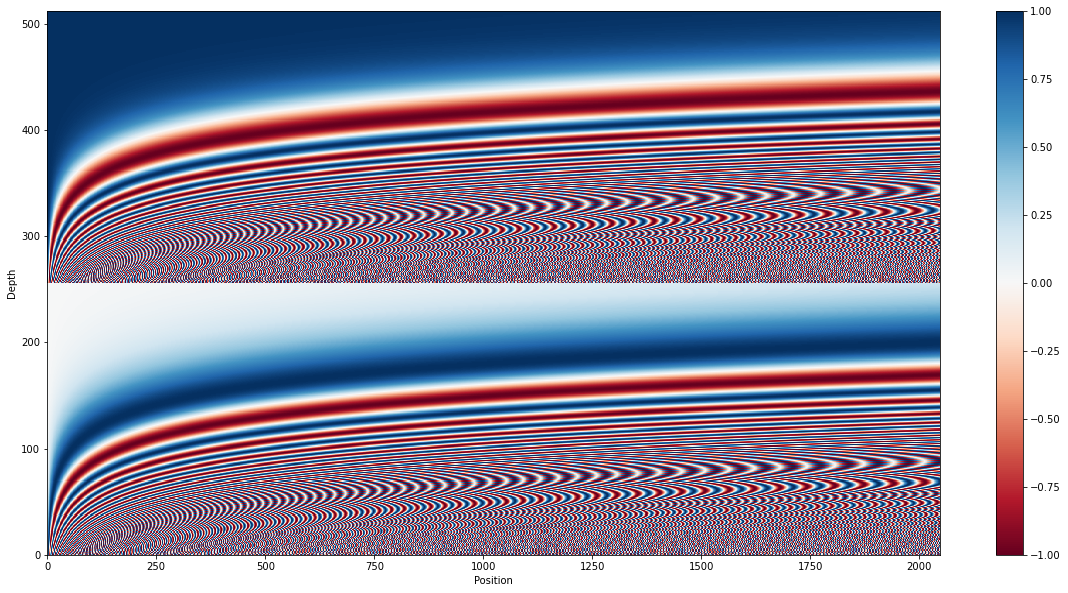

In [2]:
# Compute a positional encoding up to a maximum length.
# Usually, we set the length to a value beyond any reasonable input sequence length.
# We will not be able to use the model on sequences longer than this value.
# We also state a depth, which is the number of channels/dimensions each position is encoded with.
# Usually we set this to be the same depth that the embeddings in our model have.
pos_encoding = tut.positional_encoding(length=2048, depth=512)
print("Shape of the positional encoding:", pos_encoding.shape)

# Plot the encodings
fig = plt.figure(figsize=(20, 10)) # width, height
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

With the positional embedding at hand, we can implement a [custom layer](https://www.tensorflow.org/tutorials/customization/custom_layers) that uses [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) to get a token embedding.

You can put any functionality you like in the `call` method of your custom layer. Your layer can then later be used as a component of the model just as tensorflows build-in layers.

The position encoding in the following is a **constant** it is not trained as part of the model.

In [3]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """ A custom layer that maps a batch of input sequences in token-index representation to
        embedded sequences, i.e. each token is replaced by a high-dimensional vector.
    Args:
        vocab_size: Number of possible tokens.
        d_model: A user defined hidden dimension of the model. Depends on the complexity of the task. For real-world language models this is usually something like 512 or 1024.
        use_positional_encoding: Whether to use positional encoding of the inputs or not.
    """
    def __init__(self, vocab_size, d_model, use_positional_encoding=True):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.use_positional_encoding = use_positional_encoding
        if self.use_positional_encoding:
            self.pos_encoding = tut.positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        """ Required to correctly handle sequence padding of variable length sequences in a batch.
            We just forward this call to the compute_mask method of the embedding layer, which does
            the heavy lifting for us.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        """ Computes both token- and position embeddings.
        Args:
            x: A 2D tensor of token ids with shape (B, L)
        Returns:
            A 3D tensor of embeddings with shape (B, L, d_model)
        """
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        if self.use_positional_encoding:
            x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

### 1.2) The basic building blocks

In [4]:
class SelfAttention(tf.keras.layers.Layer):
    """ Another custom layer that computes one self attention step on the input sequences.
        It uses tf.keras.layers.MultiHeadAttention to do the heavy lifting. 
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        # layer normalization is a regularization technique that normalizes 
        # the activations of a layer for each batch sequence independently
        self.layernorm = tf.keras.layers.LayerNormalization()
        # a simple keras layer variant for "+"
        self.add = tf.keras.layers.Add()
        
    def call(self, x):
        """ Computes one self-attention step
        Args:
            x: A 3D tensor of embedded sequences with shape (B, L, d_model)
        Returns:
            A 3D tensor of updated embeddings with the same shape as the inputs.
        """
        # compute the attention output and scores
        # the scores are a by-product of the attention operation 
        # we will save them to plot them later
        attn_output, attn_scores = self.mha(
            query=x,
            value=x,
            key=x,
            return_attention_scores=True)
        self.last_attn_scores = attn_scores
        # a skip connection: add the value before the attention operation 
        # to the updated values after the attention operation
        x = self.add([x, attn_output])
        # apply layer normalization
        x = self.layernorm(x)
        return x

In [5]:
class FeedForward(tf.keras.layers.Layer):
    """ A standard feed forward neural network like those from the first course day 
        with an additional dropout layer.
        The layer also implements skip connections and layer normalization.
    Args:
        d_model: Number of dimensions for the embedding vectors.
        dff: Dimension of the feed forward layer.
        dropout_rate: A regularization parameter that controls 
                the amount of dropout applied to the feed forward outputs.
    """
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    """ One encoder step to refine sequence embeddings consisting of self attention 
        and feed forward.
    """
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = SelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [7]:
class Encoder(tf.keras.layers.Layer):
    """ The final encoder. Applies positional encoding to the inputs and 
        applies a stack of encoder layers iteratively.
    """
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.3, use_positional_encoding=True):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model, 
            use_positional_encoding=use_positional_encoding)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

## 2) A toy problem to put the transformer into practice

To get a better intuition of what a positional embedding can do for us, we want to solve the following simple problem:

Given a string with variable length consisting of random upper case characters from the latin alphabet, such that A and B each occur exactly 1 time. "Predict" whether A comes before B in the sequence (output 1) or vise versa (output 0). 

We say "predict" here although for a human this task is trivial, but for a machine learning model we will see that the notion of order inside the sequence depends on the positional encoding.

Example 1:
- Sequence: IFGIEAHWIEIFIBEJQ
- Label: 1

Example 2:
- Sequence: ZSUBUEAUFH
- Label: 0

In [8]:
def make_dataset(num_seq, len_min=40, len_max=60, batch_size=64):
    # assume that the tokens (here: upper case letters + padding token) are encoded as follows:
    # 0: padding
    # 1: A
    # 2: B
    # 3-25: all other characters
    seqs = np.random.randint(3, 26, size=(num_seq, len_max))
    lens = np.random.randint(len_min, len_max, size=num_seq)
    labels = np.zeros(num_seq)
    for i,l in enumerate(lens):
        seqs[i,l:] = 0 #terminal token padding
        pos_AB = np.random.choice(np.arange(l), size=2, replace=False)
        seqs[i, pos_AB[0]] = 1
        seqs[i, pos_AB[1]] = 2
        if pos_AB[0] < pos_AB[1]:
            labels[i] = 1
    features_dataset = tf.data.Dataset.from_tensor_slices(seqs)
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((features_dataset, labels_dataset))
    ds = ds.batch(batch_size)
    return ds

In [9]:
class SimpleTransformerEncoder(tf.keras.Model):
    """ Put everything together in a keras model for easy training.
        The idea is to let a transformer encoder encode the sequences first
        and then reduce over the sequence dimension to get a
        single embedding representing the whole sequence.
    """
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(num_layers=1, d_model=8,
                           num_heads=1, dff=8,
                           vocab_size=26,
                           dropout_rate=0.0,
                           use_positional_encoding=True)

        self.final_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        emb = self.encoder(inputs)  # (batch_size, seq_len, d_model)
        
        #reduce the sequence dimension by summing up
        emb_sums = tf.reduce_mean(emb, axis=1)
        
        logits = self.final_layer(emb_sums)  # (batch_size, 1)

        # Return the final output and the attention weights.
        return logits

In [10]:
model = SimpleTransformerEncoder()

In [11]:
ds = make_dataset(20000, len_min=10, len_max=15, batch_size=8)
for seqs, labels in ds.take(1):
    for s,l in zip(seqs, labels):
        print(f"sequence = {s} label = {l}")
model(seqs)

sequence = [15  2  7 14 17  9 19  6  1 25 23  0  0  0  0] label = 0.0
sequence = [16 25 25  1  4 19  6 13 12  2  8 23 12  0  0] label = 1.0
sequence = [12  1  7 10  5 17  2  5 10 12  0  0  0  0  0] label = 1.0
sequence = [12  1 19 11  5 10  2  6 14 18  0  0  0  0  0] label = 1.0
sequence = [18 24 24 14 23  2  1 17 11  9  0  0  0  0  0] label = 0.0
sequence = [ 2  4 12 24 24 18  4 17  5 15  1 22 20 25  0] label = 0.0
sequence = [18  4 20 15 19 12  1  7  6  3  3 18  2  0  0] label = 1.0
sequence = [25  5  1 18 11 15 11 25 21  9 14  2  0  0  0] label = 1.0


<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[-0.5292168 ],
       [-0.5312513 ],
       [-0.58069414],
       [-0.5358807 ],
       [-0.5061041 ],
       [-0.49451494],
       [-0.60226727],
       [-0.46090347]], dtype=float32)>

The model outputs logits, not probabilities. To get probabilities us `tf.math.sigmoid`.

In [12]:
model.summary()

Model: "simple_transformer_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  672       
_________________________________________________________________
dense_2 (Dense)              multiple                  9         
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_ds = make_dataset(100000, len_min=10, len_max=15, batch_size=512)
val_ds = make_dataset(1000, len_min=10, len_max=15, batch_size=512)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["binary_accuracy"])

In [14]:
model.fit(train_ds, epochs=10);

Epoch 1/10
196/196 [==============================] - 2s 6ms/step - loss: 0.6816 - binary_accuracy: 0.5014
Epoch 2/10
196/196 [==============================] - 1s 6ms/step - loss: 0.3986 - binary_accuracy: 0.7660
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 0.0090 - binary_accuracy: 0.9995
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 0.0015 - binary_accuracy: 1.0000
Epoch 5/10
196/196 [==============================] - 1s 6ms/step - loss: 7.9946e-04 - binary_accuracy: 1.0000
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 5.4709e-04 - binary_accuracy: 1.0000
Epoch 7/10
196/196 [==============================] - 1s 6ms/step - loss: 4.0590e-04 - binary_accuracy: 1.0000
Epoch 8/10
196/196 [==============================] - 1s 6ms/step - loss: 3.1541e-04 - binary_accuracy: 1.0000
Epoch 9/10
196/196 [==============================] - 1s 6ms/step - loss: 2.5143e-04 - binary_accuracy: 1.0000
Epoch 10/10
196/1

In [15]:
model.evaluate(val_ds)

2/2 [==============================] - 0s 4ms/step - loss: 1.3433e-04 - binary_accuracy: 1.0000


[0.00013432622654363513, 1.0]

## Your task: Plot the attention maps

One advantage of attention models is that their inner workings can be visualized and to some extent interpreted by humans.

Your task is to produce such a plot.

In [16]:
# get one validation example
for seqs, labels in val_ds.take(1):
    pass

# convert to numpy array
seqs = seqs.numpy()

# `tf.function` prevents us from using the attention_weights that were
# calculated on the last iteration of the loop.
# So, recalculate them outside the loop by computing one forward pass.
_ = model(seqs, training=False)

*Task*: Extract the attention scores from one attention head in one of the encoder layers in the model. Remember (check it out in the code earlier) that the `last_attn_scores` were stored as a member of the `self_attention` layer in each encoder layer. The scores will always be with respect to the last seen sequences.

Tips:
- start by accessing `self_attention` in a specific encoder layer of the model
- check out the shape of `last_attn_scores`
- you can use `ax.matshow` to visualize a matrix

In [17]:
def plot_attn(seq, layer, head):
    attention_weights = model.encoder.enc_layers[layer].self_attention.last_attn_scores.numpy()
    # print(attention_weights)
    plt.figure(figsize=(12, 8), dpi=80)
    ax = plt.gca()
    ax.matshow(attention_weights[seq,head])
    ax.set_xticks(np.arange(seqs.shape[1]))
    ax.set_yticks(np.arange(seqs.shape[1]))
    # label only 1 and 2
    labels = ["_ABcdefghijklmnopqrstuvwxyz"[x] for x in seqs[seq]]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

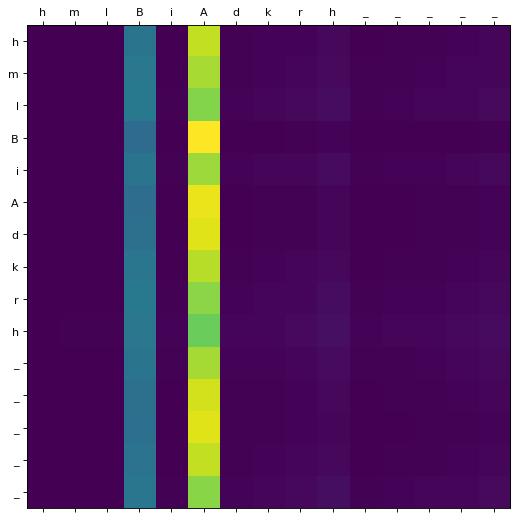

In [18]:
plot_attn(seq=0, layer=0, head=0)

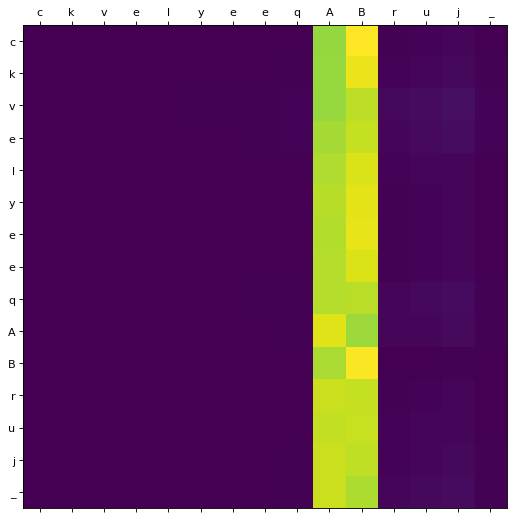

In [19]:
plot_attn(seq=3, layer=0, head=0)

You should see that all positions only attend to A and B and ignore all other positions. This makes sense, because the other positions just contain random noise. Remember that the model weights were initialized randomly. The model had no prior knowledge about the task and which positions are correlated with the labels.